# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[−20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18]$.

**Data**: RadioML Dataset

**Modulation Classification:**
We will use AutoML to create a Classifier to Predict Labels.

## Imports

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/Real\ Datasets/RadioML-Dataset/AutoML

Mounted at /gdrive
/gdrive/My Drive/Modulation-Classification/Real Datasets/RadioML-Dataset/AutoML


### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os
from sklearn.model_selection import train_test_split

# Importing Preprocessing Libraries
from Import_Functions import ImportData, ImportDatasets
from Plot_Results import EvaluateData, PlotResults

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, ReLU, Conv2D, Input, MaxPooling2D, BatchNormalization, AveragePooling2D, Reshape, ZeroPadding2D, Dropout
from tensorflow.keras.models import Model

     |████████████████████████████████| 174kB 4.3MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=f5a3f25c6dad1e17e7eb51417e8123f26778f6d24e74f06e62e6e1b391b6d24e
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=407d4caa7f4a98869e4f57b2c20d2ec9f023d64cc90e096fcbf32e0ebf8b9ed4
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## Customised AutoML Blocks

In [3]:
class SqueezeLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_node = inputs[0]
        output_node = tf.squeeze(input_node,axis=2)
        return output_node

class AddDimsLayerBlock(ak.Block):
    def build(self, hp, inputs=None):
        input_node = inputs[0]
        output_node = tf.expand_dims(input_node,axis=1)
        return output_node

class PermuteLayerBlock(ak.Block):
    def build(self, hp, shape=None, inputs=None):
        input_node = inputs[0]
        dims = len(input_node.shape.as_list()[1:])
        output_node = tf.keras.layers.Permute([*range(dims,0,-1)])(input_node)
        return output_node

Callbacks

In [4]:
EarlyStoppingCallbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

## Importing Data

In [5]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets("../Data/RML2016.10a/RML2016.10a_dict.pkl",test_size=0.2)

## AutoML ResNet Model for RadioML Dataset
For RadioML Dataset, Input Dimensions is (2,128)

### Creating Classifier

In [6]:
tf.keras.backend.clear_session()

input_node = ak.Input()
addDims_node = AddDimsLayerBlock()(input_node)
permute_node = PermuteLayerBlock()(addDims_node)
resnet_node = ak.ResNetBlock(version='v1')(permute_node)
dense_node = ak.DenseBlock()(resnet_node)
output_node = ak.ClassificationHead(num_classes=11,
                                    loss='categorical_crossentropy')(dense_node)

RadioMLClassifier = ak.AutoModel(inputs=input_node,
                                outputs=output_node,
                                overwrite=True,
                                tuner='greedy',
                                max_trials=3)

RadioMLClassifier.fit(X_Train, y_Train, epochs=3, batch_size=1536, validation_split=0.05,shuffle=True,callbacks=EarlyStoppingCallbacks)

Trial 3 Complete [00h 04m 20s]
val_loss: 2.3984456062316895

Best val_loss So Far: 2.397524356842041
Total elapsed time: 00h 13m 34s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
115/115 [==============================] - 91s 733ms/step - loss: 3.2989 - accuracy: 0.0810
Epoch 2/3
115/115 [==============================] - 83s 720ms/step - loss: 2.3965 - accuracy: 0.0824
Epoch 3/3
115/115 [==============================] - 83s 720ms/step - loss: 2.3334 - accuracy: 0.1078
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Model Summary

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 2, 128)       0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1, 2, 128)    0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 2, 1)    0           tf.expand_dims[0][0]             
______________________________________________________________________________________________

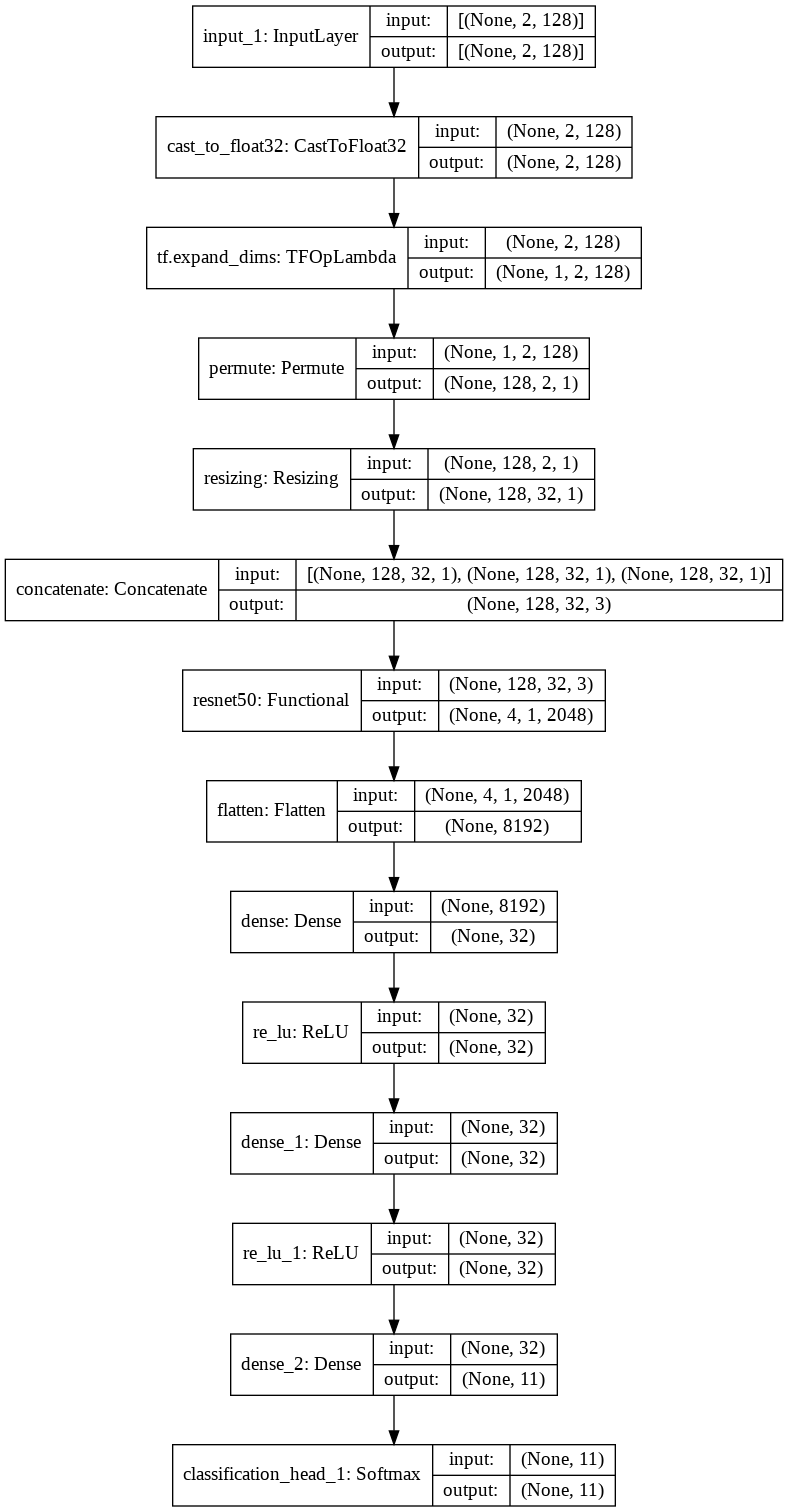

In [7]:
RadioML_Model = RadioMLClassifier.export_model()
RadioML_Model.summary()
tf.keras.backend.clear_session()
tf.keras.utils.plot_model(RadioML_Model, to_file='../Models/RadioML_Model_ResNet.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [8]:
RadioML_Model.fit(X_Train, y_Train, epochs=25, batch_size=1536, validation_split=0.05,shuffle=True)

Epoch 1/25
109/109 [==============================] - 90s 768ms/step - loss: 1.9399 - accuracy: 0.2427 - val_loss: 2.4176 - val_accuracy: 0.0909
Epoch 2/25
109/109 [==============================] - 79s 724ms/step - loss: 1.5910 - accuracy: 0.3628 - val_loss: 2.4998 - val_accuracy: 0.0909
Epoch 3/25
109/109 [==============================] - 79s 725ms/step - loss: 1.3670 - accuracy: 0.4535 - val_loss: 2.3167 - val_accuracy: 0.1465
Epoch 4/25
109/109 [==============================] - 79s 725ms/step - loss: 1.2743 - accuracy: 0.5123 - val_loss: 2.4990 - val_accuracy: 0.2215
Epoch 5/25
109/109 [==============================] - 79s 725ms/step - loss: 1.2328 - accuracy: 0.5322 - val_loss: 10.9384 - val_accuracy: 0.4284
Epoch 6/25
109/109 [==============================] - 79s 725ms/step - loss: 1.1832 - accuracy: 0.5458 - val_loss: 2.1793 - val_accuracy: 0.5372
Epoch 7/25
109/109 [==============================] - 79s 724ms/step - loss: 1.1598 - accuracy: 0.5541 - val_loss: 0.9810 - val_a

Evaluate the Model

Evaluating Model
SNR: -20 Accuracy: 0.2098863571882248
SNR: -18 Accuracy: 0.214318186044693
SNR: -16 Accuracy: 0.21863636374473572
SNR: -14 Accuracy: 0.24988636374473572
SNR: -12 Accuracy: 0.2889772653579712
SNR: -10 Accuracy: 0.3723863661289215
SNR: -8 Accuracy: 0.5014773011207581
SNR: -6 Accuracy: 0.6339772939682007
SNR: -4 Accuracy: 0.713522732257843
SNR: -2 Accuracy: 0.7795454263687134
SNR: 0 Accuracy: 0.7919318079948425
SNR: 2 Accuracy: 0.8017045259475708
SNR: 4 Accuracy: 0.7932954430580139
SNR: 6 Accuracy: 0.8134090900421143
SNR: 8 Accuracy: 0.8054545521736145
SNR: 10 Accuracy: 0.8123863339424133
SNR: 12 Accuracy: 0.8087499737739563
SNR: 14 Accuracy: 0.8102272748947144
SNR: 16 Accuracy: 0.7994318008422852
SNR: 18 Accuracy: 0.7809090614318848


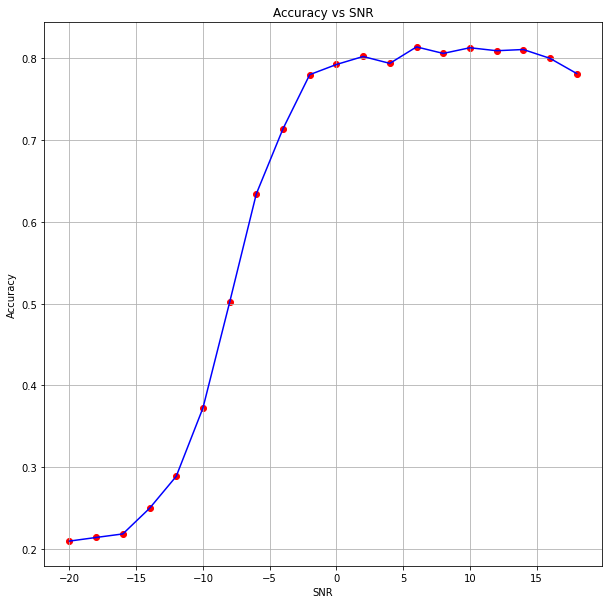

In [9]:
EvaluateData(RadioML_Model, X_Valid, y_Valid, "../Results/RadioML_Accuracy_ResNet.jpg")

Save Model

In [10]:
RadioML_Model.save("../Models/RadioML_ResNet.h5")

## AutoML CLDNN Model for RadioML Dataset

For RadioML Dataset, Input Dimensions is (2,128)

### Creating Classifier

In [12]:
tf.keras.backend.clear_session()

input_node = ak.Input()
addDims_node = AddDimsLayerBlock()(input_node)
permute_node = PermuteLayerBlock()(addDims_node)
conv_node = ak.ConvBlock()(permute_node)
reshape_node = SqueezeLayerBlock()(conv_node)
rnn_node = ak.RNNBlock(return_sequences=True,
                       bidirectional=True,
                       layer_type='lstm')(reshape_node)
dense_node = ak.DenseBlock()(rnn_node)
output_node = ak.ClassificationHead(num_classes=11,
                                    loss='categorical_crossentropy')(dense_node)

RadioMLClassifier = ak.AutoModel(inputs=input_node,
                                outputs=output_node,
                                overwrite=True,
                                tuner='greedy',
                                max_trials=10)

RadioMLClassifier.fit(X_Train, y_Train, epochs=10, batch_size=1024, validation_split=0.05,shuffle=True,callbacks=EarlyStoppingCallbacks)

Trial 10 Complete [00h 01m 22s]
val_loss: 2.0401384830474854

Best val_loss So Far: 2.0181679725646973
Total elapsed time: 00h 12m 49s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
172/172 [==============================] - 14s 43ms/step - loss: 2.3980 - accuracy: 0.0795
Epoch 2/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3978 - accuracy: 0.1163
Epoch 3/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3971 - accuracy: 0.1214
Epoch 4/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3894 - accuracy: 0.0988
Epoch 5/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3402 - accuracy: 0.1049
Epoch 6/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3312 - accuracy: 0.1052
Epoch 7/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3362 - accuracy: 0.1033
Epoch 8/10
172/172 [==============================] - 7s 43ms/step - loss: 2.3322 - accuracy: 0.1047
Epoch 9/10
172/172

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 2, 128)            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1, 2, 128)         0         
_________________________________________________________________
permute (Permute)            (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 1, 32)         0     

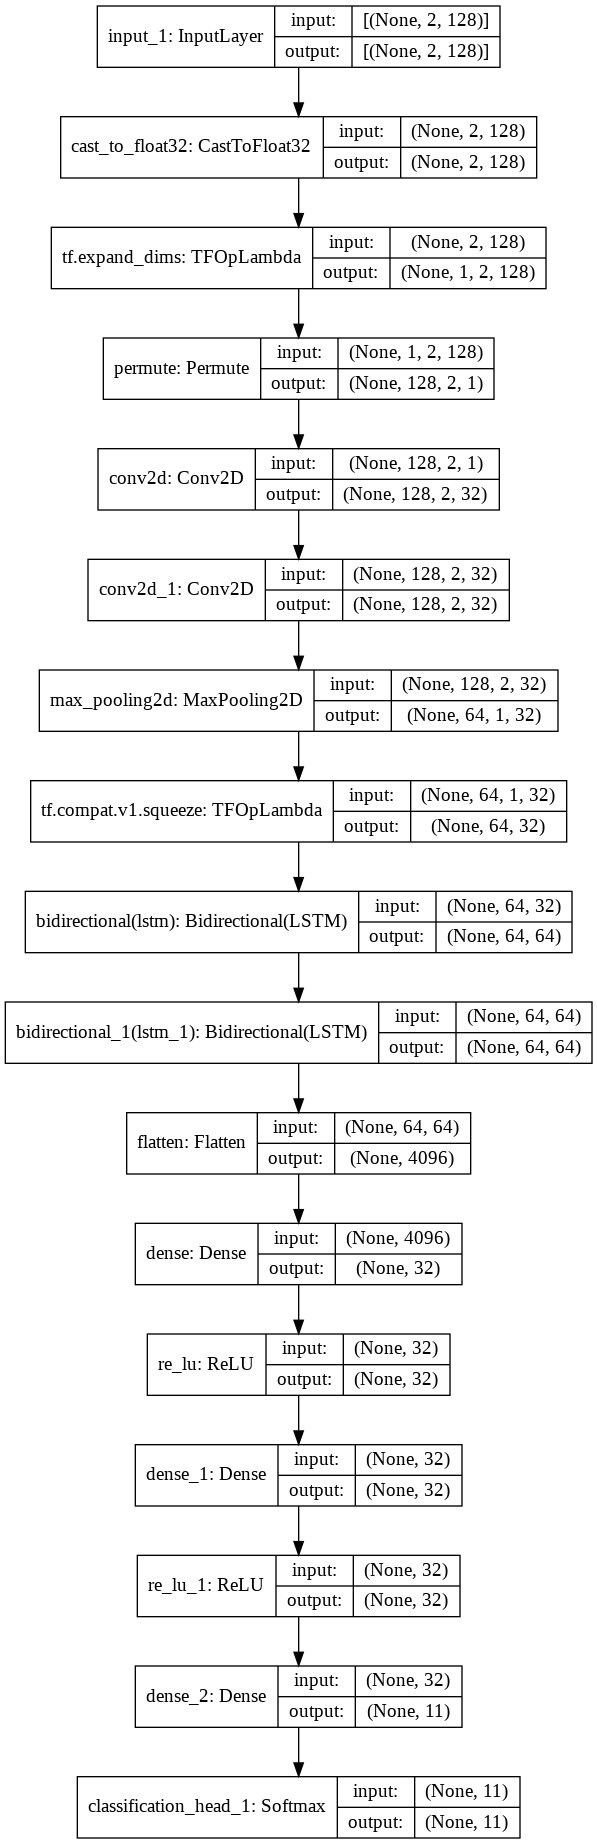

In [13]:
RadioML_Model = RadioMLClassifier.export_model()
RadioML_Model.summary()
tf.keras.backend.clear_session()
tf.keras.utils.plot_model(RadioML_Model, to_file='../Models/RadioML_Model_CLDNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [14]:
RadioML_Model.fit(X_Train, y_Train, epochs=100, batch_size=1024, validation_split=0.05,shuffle=True)

Epoch 1/100
164/164 [==============================] - 15s 49ms/step - loss: 2.1465 - accuracy: 0.1853 - val_loss: 1.9211 - val_accuracy: 0.2812
Epoch 2/100
164/164 [==============================] - 6s 39ms/step - loss: 2.0763 - accuracy: 0.2301 - val_loss: 1.7961 - val_accuracy: 0.3093
Epoch 3/100
164/164 [==============================] - 6s 39ms/step - loss: 2.0083 - accuracy: 0.2459 - val_loss: 1.6746 - val_accuracy: 0.3401
Epoch 4/100
164/164 [==============================] - 6s 39ms/step - loss: 1.9573 - accuracy: 0.2663 - val_loss: 1.6386 - val_accuracy: 0.3566
Epoch 5/100
164/164 [==============================] - 6s 39ms/step - loss: 1.9125 - accuracy: 0.2864 - val_loss: 1.5247 - val_accuracy: 0.4187
Epoch 6/100
164/164 [==============================] - 6s 39ms/step - loss: 1.8703 - accuracy: 0.3049 - val_loss: 1.4566 - val_accuracy: 0.4468
Epoch 7/100
164/164 [==============================] - 6s 39ms/step - loss: 1.8332 - accuracy: 0.3205 - val_loss: 1.3515 - val_accuracy

Evaluate the Model

Evaluating Model
SNR: -20 Accuracy: 0.09409090876579285
SNR: -18 Accuracy: 0.0949999988079071
SNR: -16 Accuracy: 0.09386363625526428
SNR: -14 Accuracy: 0.10999999940395355
SNR: -12 Accuracy: 0.13625000417232513
SNR: -10 Accuracy: 0.172272726893425
SNR: -8 Accuracy: 0.2684091031551361
SNR: -6 Accuracy: 0.3686363697052002
SNR: -4 Accuracy: 0.4444318115711212
SNR: -2 Accuracy: 0.49852272868156433
SNR: 0 Accuracy: 0.5987499952316284
SNR: 2 Accuracy: 0.6575000286102295
SNR: 4 Accuracy: 0.6871590614318848
SNR: 6 Accuracy: 0.7230681777000427
SNR: 8 Accuracy: 0.7069318294525146
SNR: 10 Accuracy: 0.7180681824684143
SNR: 12 Accuracy: 0.7368181943893433
SNR: 14 Accuracy: 0.7286363840103149
SNR: 16 Accuracy: 0.7188636660575867
SNR: 18 Accuracy: 0.7144318222999573


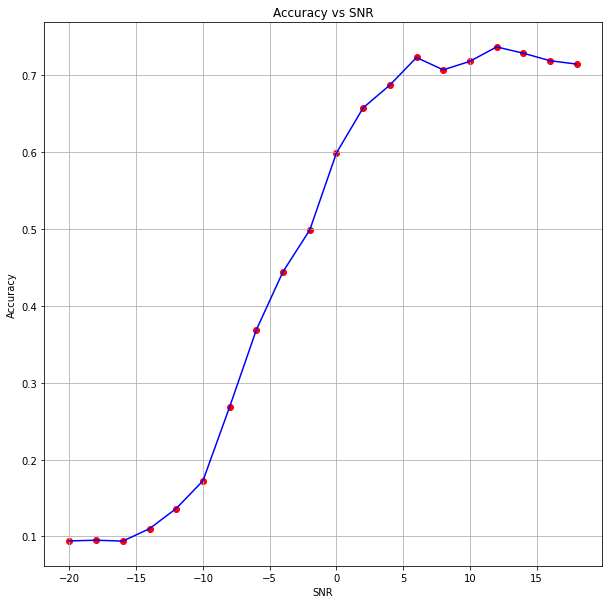

In [15]:
EvaluateData(RadioML_Model, X_Valid, y_Valid, "../Results/RadioML_Accuracy_CLDNN.jpg")

Save Model

In [16]:
RadioML_Model.save("../Models/RadioML_CLDNN.h5")

## AutoML CNN Model for RadioML Dataset

For RadioML Dataset, Input Dimensions is (2,128)

### Creating Classifier

In [17]:
tf.keras.backend.clear_session()

input_node = ak.Input()
addDims_node = AddDimsLayerBlock()(input_node)
permute_node = PermuteLayerBlock()(addDims_node)
conv_node = ak.ConvBlock()(permute_node)
dense_node = ak.DenseBlock()(conv_node)
output_node = ak.ClassificationHead(num_classes=11,
                                    loss='categorical_crossentropy')(dense_node)

RadioMLClassifier = ak.AutoModel(inputs=input_node,
                                outputs=output_node,
                                overwrite=True,
                                tuner='greedy',
                                max_trials=20)

RadioMLClassifier.fit(X_Train, y_Train, epochs=10, batch_size=2048, validation_split=0.05,shuffle=True,callbacks=EarlyStoppingCallbacks)

Trial 20 Complete [00h 00m 54s]
val_loss: 2.197554588317871

Best val_loss So Far: 2.197554588317871
Total elapsed time: 00h 10m 51s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
86/86 [==============================] - 5s 54ms/step - loss: 2.3979 - accuracy: 0.0803
Epoch 2/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3979 - accuracy: 0.1168
Epoch 3/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3978 - accuracy: 0.1264
Epoch 4/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3975 - accuracy: 0.1290
Epoch 5/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3969 - accuracy: 0.1246
Epoch 6/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3955 - accuracy: 0.1189
Epoch 7/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3926 - accuracy: 0.1189
Epoch 8/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3867 - accuracy: 0.1199
Epoch 9/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3763 - accuracy: 0.1209
Epoch 10/10
86/86 [==============================] - 5s 53ms/step - loss: 2.3620 - accuracy: 0.1215
INFO:tens

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 2, 128)            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1, 2, 128)         0         
_________________________________________________________________
permute (Permute)            (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 2, 32)        9248  

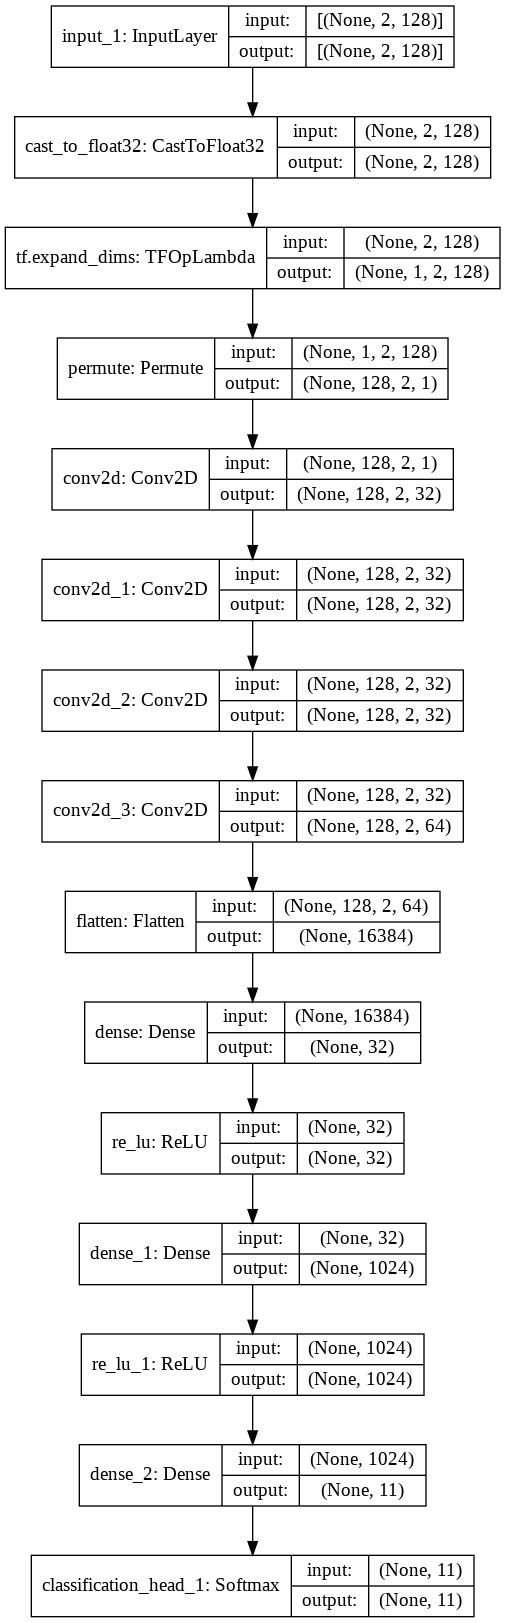

In [18]:
RadioML_Model = RadioMLClassifier.export_model()
tf.keras.backend.clear_session()
RadioML_Model.summary()
tf.keras.utils.plot_model(RadioML_Model, to_file='../Models/RadioML_Model_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [19]:
RadioML_Model.fit(X_Train, y_Train, epochs=100, batch_size=1024, validation_split=0.05,shuffle=True)

Epoch 1/100
164/164 [==============================] - 5s 25ms/step - loss: 2.2569 - accuracy: 0.1440 - val_loss: 2.1170 - val_accuracy: 0.1858
Epoch 2/100
164/164 [==============================] - 4s 23ms/step - loss: 2.2036 - accuracy: 0.1755 - val_loss: 2.0515 - val_accuracy: 0.2344
Epoch 3/100
164/164 [==============================] - 4s 23ms/step - loss: 2.1587 - accuracy: 0.1957 - val_loss: 1.9920 - val_accuracy: 0.2570
Epoch 4/100
164/164 [==============================] - 4s 23ms/step - loss: 2.1214 - accuracy: 0.2083 - val_loss: 1.9439 - val_accuracy: 0.2611
Epoch 5/100
164/164 [==============================] - 4s 23ms/step - loss: 2.0944 - accuracy: 0.2149 - val_loss: 1.9087 - val_accuracy: 0.2693
Epoch 6/100
164/164 [==============================] - 4s 23ms/step - loss: 2.0722 - accuracy: 0.2215 - val_loss: 1.8729 - val_accuracy: 0.2828
Epoch 7/100
164/164 [==============================] - 4s 23ms/step - loss: 2.0468 - accuracy: 0.2319 - val_loss: 1.8247 - val_accuracy:

Evaluate the Model

Evaluating Model
SNR: -20 Accuracy: 0.09352272748947144
SNR: -18 Accuracy: 0.09534090757369995
SNR: -16 Accuracy: 0.09795454889535904
SNR: -14 Accuracy: 0.11340909451246262
SNR: -12 Accuracy: 0.13659091293811798
SNR: -10 Accuracy: 0.18977272510528564
SNR: -8 Accuracy: 0.25090909004211426
SNR: -6 Accuracy: 0.3097727298736572
SNR: -4 Accuracy: 0.3897727131843567
SNR: -2 Accuracy: 0.4727272689342499
SNR: 0 Accuracy: 0.5565909147262573
SNR: 2 Accuracy: 0.5962499976158142
SNR: 4 Accuracy: 0.6050000190734863
SNR: 6 Accuracy: 0.6238636374473572
SNR: 8 Accuracy: 0.6278409361839294
SNR: 10 Accuracy: 0.6254545450210571
SNR: 12 Accuracy: 0.629659116268158
SNR: 14 Accuracy: 0.6372727155685425
SNR: 16 Accuracy: 0.6138636469841003
SNR: 18 Accuracy: 0.620340883731842


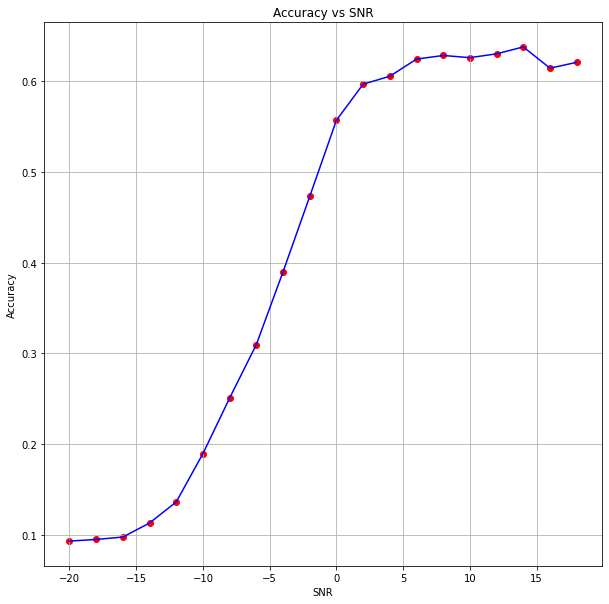

In [20]:
EvaluateData(RadioML_Model, X_Valid, y_Valid, "../Results/RadioML_Accuracy_CNN.jpg")

Save Model

In [21]:
RadioML_Model.save("../Models/RadioML_CNN.h5")

## AutoML RNN Model for RadioML Dataset

For RadioML Dataset, Input Dimensions is (2,128)

### Creating Classifier

In [22]:
tf.keras.backend.clear_session()

input_node = ak.Input()
permute_node = PermuteLayerBlock()(input_node)
rnn_node = ak.RNNBlock(return_sequences=True,
                       bidirectional=True,
                       layer_type='lstm')(permute_node)
dense_node = ak.DenseBlock()(rnn_node)
output_node = ak.ClassificationHead(num_classes=11,
                                    loss='categorical_crossentropy')(dense_node)

RadioMLClassifier = ak.AutoModel(inputs=input_node,
                                outputs=output_node,
                                overwrite=True,
                                tuner='greedy',
                                max_trials=20)

RadioMLClassifier.fit(X_Train, y_Train, epochs=10, batch_size=2048, validation_split=0.05,shuffle=True,callbacks=EarlyStoppingCallbacks)

Trial 20 Complete [00h 01m 18s]
val_loss: 1.82602059841156

Best val_loss So Far: 1.82602059841156
Total elapsed time: 00h 24m 53s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
86/86 [==============================] - 12s 71ms/step - loss: 2.3991 - accuracy: 0.0814
Epoch 2/10
86/86 [==============================] - 6s 71ms/step - loss: 2.3927 - accuracy: 0.1165
Epoch 3/10
86/86 [==============================] - 6s 71ms/step - loss: 2.4144 - accuracy: 0.1008
Epoch 4/10
86/86 [==============================] - 6s 70ms/step - loss: 2.3962 - accuracy: 0.1014
Epoch 5/10
86/86 [==============================] - 6s 70ms/step - loss: 2.3878 - accuracy: 0.1117
Epoch 6/10
86/86 [==============================] - 6s 71ms/step - loss: 2.4182 - accuracy: 0.0917
Epoch 7/10
86/86 [==============================] - 6s 71ms/step - loss: 2.3651 - accuracy: 0.0857
Epoch 8/10
86/86 [==============================] - 6s 71ms/step - loss: 2.4000 - accuracy: 0.1021
Epoch 9/10
86/86 [==============================] - 6s 72ms/step - loss: 2.3985 - accuracy: 0.0856
Epoch 10/10
86/86 [==============================] - 6s 71ms/step - loss: 2.3985 - accuracy: 0.0851


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 2, 128)            0         
_________________________________________________________________
permute (Permute)            (None, 128, 2)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 4)            80        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 4)            112       
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416 

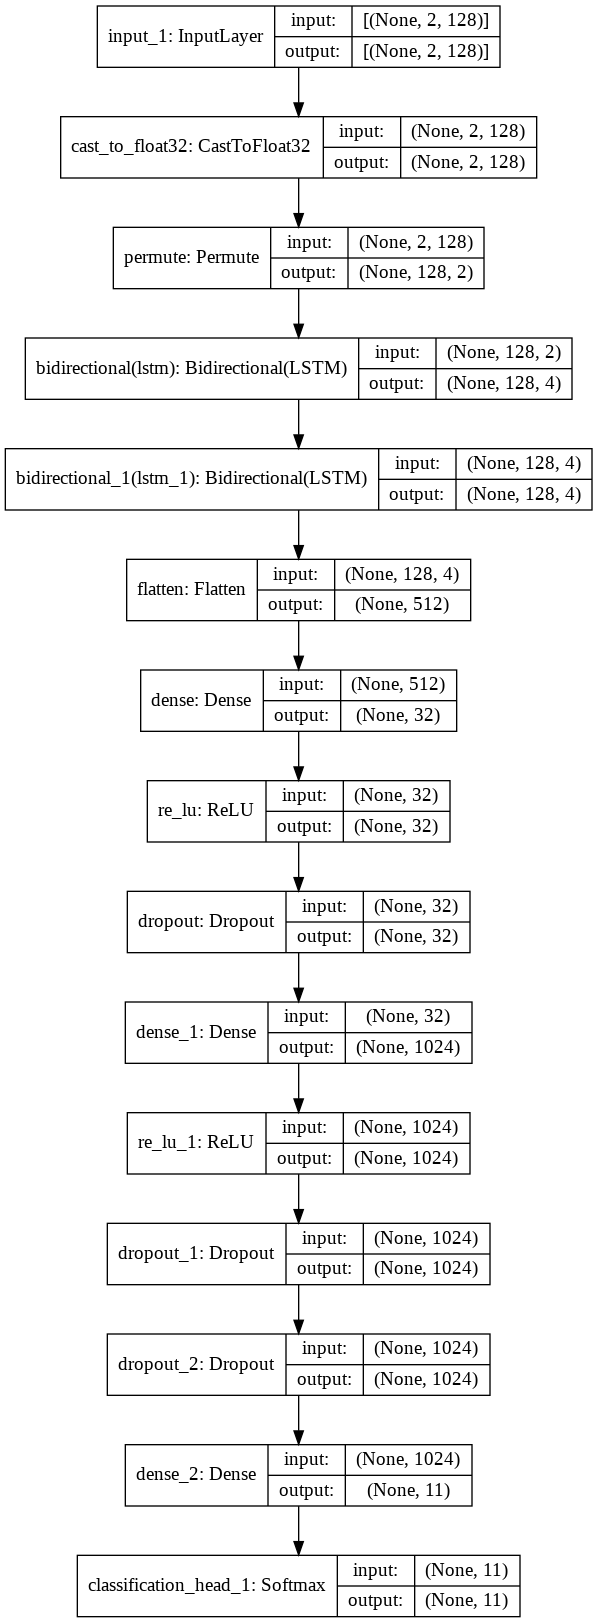

In [23]:
RadioML_Model = RadioMLClassifier.export_model()
RadioML_Model.summary()
tf.keras.backend.clear_session()
tf.keras.utils.plot_model(RadioML_Model, to_file='../Models/RadioML_Model_RNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating Model

Training the Model

In [24]:
RadioML_Model.fit(X_Train, y_Train, epochs=100, batch_size=1024, validation_split=0.05,shuffle=True)

Epoch 1/100
164/164 [==============================] - 15s 52ms/step - loss: 2.2431 - accuracy: 0.1530 - val_loss: 1.9651 - val_accuracy: 0.2675
Epoch 2/100
164/164 [==============================] - 7s 42ms/step - loss: 2.1523 - accuracy: 0.1967 - val_loss: 1.9410 - val_accuracy: 0.2720
Epoch 3/100
164/164 [==============================] - 7s 42ms/step - loss: 2.1380 - accuracy: 0.2022 - val_loss: 1.9061 - val_accuracy: 0.2765
Epoch 4/100
164/164 [==============================] - 7s 42ms/step - loss: 2.1168 - accuracy: 0.2103 - val_loss: 1.8691 - val_accuracy: 0.2990
Epoch 5/100
164/164 [==============================] - 7s 42ms/step - loss: 2.1059 - accuracy: 0.2164 - val_loss: 1.8698 - val_accuracy: 0.2999
Epoch 6/100
164/164 [==============================] - 7s 42ms/step - loss: 2.0998 - accuracy: 0.2169 - val_loss: 1.8534 - val_accuracy: 0.2970
Epoch 7/100
164/164 [==============================] - 7s 42ms/step - loss: 2.0925 - accuracy: 0.2193 - val_loss: 1.8586 - val_accuracy

Evaluate the Model

Evaluating Model
SNR: -20 Accuracy: 0.09238636493682861
SNR: -18 Accuracy: 0.09488636255264282
SNR: -16 Accuracy: 0.09477272629737854
SNR: -14 Accuracy: 0.10090909153223038
SNR: -12 Accuracy: 0.11465909332036972
SNR: -10 Accuracy: 0.14784090220928192
SNR: -8 Accuracy: 0.20545454323291779
SNR: -6 Accuracy: 0.28022727370262146
SNR: -4 Accuracy: 0.3519318103790283
SNR: -2 Accuracy: 0.4220454692840576
SNR: 0 Accuracy: 0.49443182349205017
SNR: 2 Accuracy: 0.5292045474052429
SNR: 4 Accuracy: 0.5463636517524719
SNR: 6 Accuracy: 0.5569317936897278
SNR: 8 Accuracy: 0.5590909123420715
SNR: 10 Accuracy: 0.5672727227210999
SNR: 12 Accuracy: 0.5660227537155151
SNR: 14 Accuracy: 0.5639773011207581
SNR: 16 Accuracy: 0.557840883731842
SNR: 18 Accuracy: 0.5546590685844421


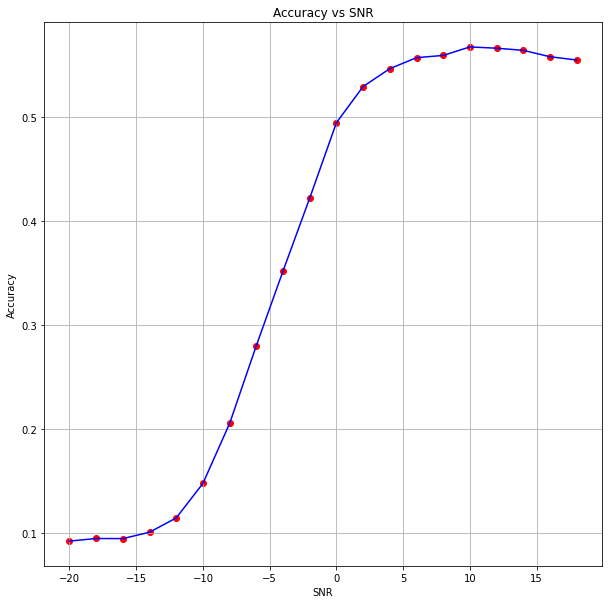

In [25]:
EvaluateData(RadioML_Model, X_Valid, y_Valid, "../Results/RadioML_Accuracy_RNN.jpg")

Save Model

In [26]:
RadioML_Model.save("../Models/RadioML_RNN.h5")

## Plot Results


### RadioML Model

Importing Data and Models

In [27]:
RadioML_ResNet = tf.keras.models.load_model("../Models/RadioML_ResNet.h5")
RadioML_CLDNN = tf.keras.models.load_model("../Models/RadioML_CLDNN.h5")
RadioML_CNN = tf.keras.models.load_model("../Models/RadioML_CNN.h5")
RadioML_RNN = tf.keras.models.load_model("../Models/RadioML_RNN.h5")

Plotting Results

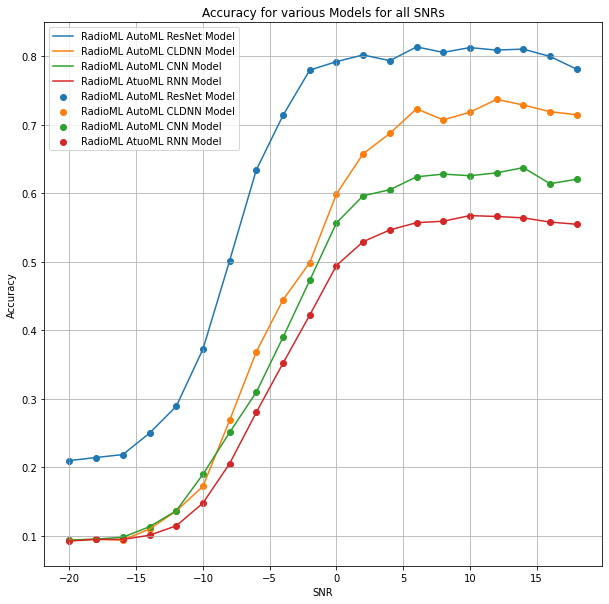

In [28]:
Models = {"RadioML AutoML ResNet Model":RadioML_ResNet, 
          "RadioML AutoML CLDNN Model":RadioML_CLDNN,
          "RadioML AutoML CNN Model":RadioML_CNN, 
          "RadioML AtuoML RNN Model":RadioML_RNN}
PlotResults(Models, X_Valid, y_Valid, "../Results/RadioML_Accuracies.jpg")